In [1]:
%load_ext autoreload
%reload_ext autoreload

In [2]:
import numpy as np
import open3d as o3d
from datetime import datetime
from PIL import Image

from utils import *
from manus_utils import ManusData, rotate_pts

import sys
manopth_dir = 'C:/Users/lucas/Desktop/UPC/MIT/manopth/'
sys.path.insert(1, manopth_dir)

from manus.utils import Pressure
from manus.sensors import SensorsLocation

In [3]:
data_dir = "C:/Users/lucas/Desktop/UPC/MIT/tactile2object/real_data/data"
recording = "20210803/r4/"
recording_dir = os.path.join(data_dir, recording)

for name in os.listdir(recording_dir):
    name_pth = os.path.join(recording_dir, name)
    
    if os.path.isdir(name_pth):
        print("cameras_dir:", name)
        cameras_dir = name_pth
        
    elif ".hdf5" in name:
        print("pressure_file:", name)
        perssure_pth = name_pth
        
    elif ".xlsx" in name:
        print("manus_file:", name)
        manus_pth = name_pth
        
#cameras_dir = os.path.join(recording_dir, "20210722_152500")
#perssure_pth = os.path.join(recording_dir, ".hdf5")
#manus_pth = os.path.join(recording_dir, ".fbx")

pressure_file: 08032021_3.hdf5
manus_file: 08032021_3.xlsx
cameras_dir: 20210803_161347


# Load data

In [4]:
%%capture

cameras = ["020122061233", "821312060044", "020122061651", "821312062243"]

intrinsics = Intrinsics(cameras_dir, use_txt=False)
extrinsics = Extrinsics(cameras_dir)
rgbds = RGBD(cameras_dir)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)
apriltags = AprilTags(cameras_dir, intrinsics, extrinsics, cameras=cameras)
stitched_pcd = Stitching_pcds(intrinsics, extrinsics, rgbds, cameras)

pressure = Pressure(perssure_pth, lim_low=3, lim_high=50)

manus = ManusData(manus_pth, manopth_dir)

glove_sensor_path = os.path.join(manopth_dir, 'data/glove_vis_sensor_new.csv')
sensors_location = SensorsLocation(glove_sensor_path)

# Synchronize

#### Get timestamps

In [5]:
# Camera timestamps
ts_camera = get_camera_timestamps(cameras_dir)

# Pressure timestamps
ts_pressure = pressure.ts_touch

# MANUS timestamp
ts_manus = manus.get_ts()

#### Find pressure camera offset


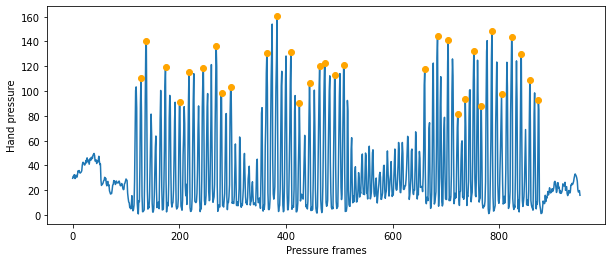

In [6]:
pressure.plot_peaks(height=80)

In [7]:
# Index of first pressure peak 
idx_first_p = pressure.get_peaks(height=80)[0]
# Timestamp of first pressure peak
ts_first_p = pressure.ts_touch[idx_first_p]

# Frame of first pressure in camera
frame_first_c = 108
# Timestamp of first pressure in camera
ts_first_c = ts_camera[frame_first_c]

# Offset between pressure and camera
pc_offset = ts_first_p - ts_first_c

#### Find manus camera offset


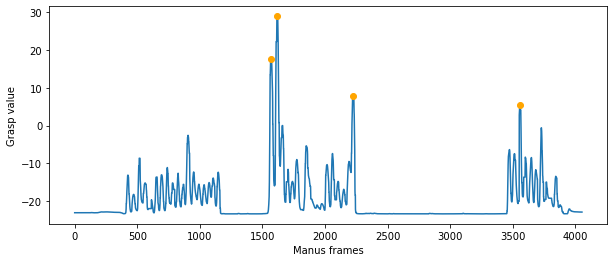

In [8]:
manus.plot_grasps(height=5)

In [9]:
manus.get_grasps(height=5)

array([1569, 1618, 2225, 3558], dtype=int64)

In [10]:
# Index of first manus grasp peak 
idx_first_m = 425
# Timestamp of first manus grasp peak
ts_first_m = ts_manus[idx_first_m]

# Frame of first grasp in camera
frame_first_c = 108
# Timestamp of first pressure in camera
ts_first_c = ts_camera[frame_first_c]

# Offset between pressure and camera
mc_offset = ts_first_m - ts_first_c

In [11]:
datetime.utcfromtimestamp(ts_first_m) - datetime.utcfromtimestamp(ts_first_c)

datetime.timedelta(seconds=5, microseconds=807704)

#### Synchronize pressure + camera + manus

In [12]:
synchronize = Synchronizer(ts_p=ts_pressure, ts_c=ts_camera, ts_m=ts_manus, pc_offset=pc_offset, mc_offset=0)

# Project MANO to camera

#### Load viewpoints

In [13]:
width = 640
height = 480

cx = width / 2 - 0.5
cy = height / 2 - 0.5

for camera in cameras:
    camera_viewpoint = o3d.camera.PinholeCameraParameters()
    camera_viewpoint.extrinsic = extrinsics.from_camera(camera=camera)
    fx, fy, _, _ = intrinsics.params_from_camera(camera=camera)
    camera_viewpoint.intrinsic = o3d.camera.PinholeCameraIntrinsic(width, height, fx, fy, cx, cy)

    viewpoint_file = os.path.join(cameras_dir, f"{camera}_viewpoint.json")
    o3d.io.write_pinhole_camera_parameters(viewpoint_file, camera_viewpoint)

#### View single frame from single camera

In [ ]:
keypoints = Keypoints(manus_pth)
keypoints.from_frame(frame)
hand_verts, hand_joints, hand_faces = get_MANO_params(all_keypoints * manus_scale, mano_root=mano_root)

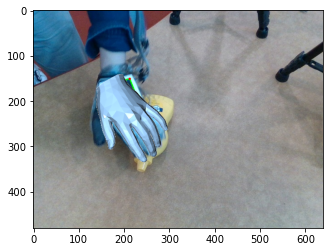

In [18]:
frame_c = 1140 #590,1200
frame_c = str(frame_c).zfill(6)
frame_m = synchronize.camera_to_manus(frame_c)
#pcd = stitched_pcd[frame_c]

camera = cameras[1]
viewpoint_file = os.path.join(cameras_dir, f"{camera}_viewpoint.json")

corners_w = apriltags.corners_w(idx=frame_c)

if corners_w is not None:
    rectangle = get_rectangle_from_corners(corners_w)
    mesh_hand = manus.from_corners(frame_m, corners_w)
    
    img_mano = save_draw_geometries(mesh_hand, None, viewpoint_file, width=width, height=height).astype(np.uint8)
    img_camera = apriltags.from_idx_camera(frame_c, camera).get_image(show=False)
    
    white_idx = np.argwhere(np.sum(img_mano, axis=-1) > 764)
    img_camera_mano = img_mano
    img_camera_mano[white_idx[:,0],white_idx[:,1],:] = img_camera[white_idx[:,0], white_idx[:,1],:]
    
    plt.imshow(img_camera_mano)

#### Plot in MANO 3D

In [ ]:
rotate_pts(pts_m_verts)

In [ ]:
pts_m_verts = np.asarray(mesh_hand.vertices)[[204, 229, 145, 20], :]
center_m_verts = pts_m_verts.mean(axis=0)

normal_m_verts = np.cross(pts_m_verts[2] - pts_m_verts[1], pts_m_verts[0] - pts_m_verts[1]);
normal_m_verts = normal_m_verts / np.linalg.norm(normal_m_verts)
translated_points = pts_m_verts - center_m_verts





In [ ]:
pts_m_verts = np.asarray(mesh_hand.vertices)[[204, 229, 145, 20], :]
pts_m_verts_balls = get_balls_from_corners(pts_m_verts, color=[1,0,0])
corners_w_balls = get_balls_from_corners(corners_w[4:])

kk =  get_balls_from_corners(rotate_pts(pts_m_verts, rotation_degrees=50), color=[0,0,0])

o3d.visualization.draw_geometries([mesh_hand] + pts_m_verts_balls + corners_w_balls + kk)

#### Save from one camera

In [19]:
camera = cameras[1]

out_dir = os.path.join(apriltags.cameras_dir, "imgs", "camera_manus", camera)

if not os.path.exists(out_dir):
    os.makedirs(out_dir)
    
viewpoint_file = os.path.join(cameras_dir, f"{camera}_viewpoint.json")


for frame_c in range(0, 1759): #1759
    frame_c = str(frame_c).zfill(6)
    frame_m = synchronize.camera_to_manus(frame_c)

    img_camera = apriltags.from_idx_camera(frame_c, camera).get_image(show=False) 

    corners_w = apriltags.corners_w(idx=frame_c)
    
    if corners_w is None:
        im = Image.fromarray(img_camera, 'RGB')
        
    
    else:
        rectangle = get_rectangle_from_corners(corners_w)
        mesh_hand = manus.from_corners(frame_m, corners_w)

        img_mano = save_draw_geometries([mesh_hand, rectangle], None, viewpoint_file, width=width, height=height)


        white_idx = np.argwhere(np.sum(img_mano, axis=-1)  > 764)
        img_camera_mano = img_mano
        img_camera_mano[white_idx[:,0],white_idx[:,1],:] = img_camera[white_idx[:,0], white_idx[:,1],:]
        
        im = Image.fromarray(img_camera_mano, 'RGB')
    
    out_pth = os.path.join(out_dir, f"img_{frame_c}.png")
    im.save(out_pth)

IndexError: index 1756 is out of bounds for axis 0 with size 1756

# Chose MANO scale

In [ ]:
from manus_utils import Keypoints


mano_joints = np.array([[  95.6699,    6.3834,    6.1863],
        [  68.2177,   -9.1389,  -16.0171],
        [  43.1887,   -8.2476,  -33.9248],
        [  27.1294,  -13.6806,  -55.0594],
        [   4.5444,  -18.0950,  -81.0249],
        [  68.8040,    1.1831,  -80.2270],
        [  64.2809,    5.1924, -112.6672],
        [  62.8275,    3.8940, -134.7757],
        [  62.3600,    2.9524, -159.9292],
        [  92.3231,    4.9045,  -88.4745],
        [  95.6978,    6.7658, -119.9748],
        [  98.0122,    5.5137, -143.1011],
        [ 101.4963,    6.1466, -169.3283],
        [ 116.4946,    2.4260,  -77.2313],
        [ 119.5775,    4.4930, -105.8353],
        [ 125.5284,    2.8049, -129.8369],
        [ 131.2202,    2.4269, -154.8938],
        [ 133.9052,   -3.5569,  -65.4849],
        [ 145.1692,   -3.4951,  -83.3408],
        [ 154.3528,   -4.1862,  -99.8988],
        [ 163.0114,   -5.5293, -118.2463]])

keypoints = Keypoints(manus_pth)

In [ ]:
manus_joints = keypoints.from_frame(0)

In [ ]:
dist_mano = 0
dist_manus = 0

joints = [(0,1),(1,2),(2,3),(3,4),(5,6),(6,7),(7,8),(9,10),(10,11),(11,12),(13,14),(14,15),(15,16),(17,18),(18,19),(19,20)]

for a,b in joints:

    dist_mano += np.linalg.norm(mano_joints[b] - mano_joints[a])
    dist_manus += np.linalg.norm(manus_joints[b] - manus_joints[a])

In [ ]:
dist_mano/dist_manus